In [4]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-331-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-cg-toolkit' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common-390' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common-410' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common-415' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common-418' for glob 'nvidia*'
Note, selecting 'nvidi

In [5]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2020-02-15 16:39:25--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.189.146
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.189.146|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?FhuB12PXxsCnc-4tQYO7sZ6NpGbd-knn7ryxNnXo1nGlYCyA42F8jaDlFPEOwW3Ma8ztLBZSlEdMYbKv2758BwHKz3YkfuwzwKRi0P4FxBmVuHzA1RfwfKXzkAChMajSyweRfGmn0EeXEC3KuxexUm7i5d8c-jdFWQ3QfB-i8zKR0WQp_Rj4Nvv8vi-MbcCS2HghWzJThtg-qIgFtTY [following]
--2020-02-15 16:39:26--  https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?FhuB12PXxsCnc-4tQYO7sZ6NpGbd-knn7ryxNnXo1nGlYCyA42F8jaDlFPEOwW3Ma8ztLBZSlEdMYbKv2758BwHKz3YkfuwzwKRi0P4FxBmVuHzA1RfwfK

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


In [0]:
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'

In [8]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Wed_Apr_11_23:16:29_CDT_2018
Cuda compilation tools, release 9.2, V9.2.88


In [10]:
%%file mul_global.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define BLOCK_SIZE 16

__global__ void MatrixMulKernel(float *M, float *N, float *P, int Width)
{ 
    int Row = blockIdx.y * blockDim.y + threadIdx.y; 
    int Col = blockIdx.x * blockDim.x + threadIdx.x;
    
    if( Col < Width && Row < Width) 
    {
    	float Pvalue = 0;
        for(int k = 0; k < Width; ++k) 
        {
            Pvalue += M[Row * Width + k] * N[k * Width + Col];
        }
        P[Row * Width + Col] = Pvalue;
    }
} 


void cpu_matrix_mult(float *M, float *N, float *P, int Width) {
    for (int i = 0; i < Width; ++i) 
    {
        for (int j = 0; j < Width; ++j) 
        {
            int tmp = 0.0;
            for(int k = 0; k < Width; ++k) 
            {
                tmp += M[i * Width + k] * N[k * Width + j];
            }
            P[i * Width + j] = tmp;
        }
    }
}


int main(int argc, char* argv[])
{
    int Width;

    Width = strtol(argv[1], NULL, 10);
	
    srand(3333);

    float *h_a=0, *h_b=0, *h_c=0, *h_cc=0;
    cudaMallocHost((void **) &h_a, sizeof(float)*Width*Width);
    cudaMallocHost((void **) &h_b, sizeof(float)*Width*Width);
    cudaMallocHost((void **) &h_c, sizeof(float)*Width*Width);
    cudaMallocHost((void **) &h_cc, sizeof(float)*Width*Width);	    

    if(h_a==0 || h_b==0 || h_c==0 || h_cc==0)
    {
	printf("No asignacion de memoria\n");
	return 1;
    }
    
    for (int i = 0; i < Width; ++i) {
        for (int j = 0; j < Width; ++j) {
            h_a[i * Width + j] = rand()%1024;
        }
    }

    for (int i = 0; i < Width; ++i) {
        for (int j = 0; j < Width; ++j) {
            h_b[i * Width + j] = rand()%1024;
        }
    }

    float gpu_time_ms;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start, 0);
    float *d_a=0, *d_b=0, *d_c=0;
    cudaMalloc((void **) &d_a, sizeof(float)*Width*Width);
    cudaMalloc((void **) &d_b, sizeof(float)*Width*Width);
    cudaMalloc((void **) &d_c, sizeof(float)*Width*Width);

    if(d_a==0 || d_b==0 || d_c==0)
    {
  		printf("No asignacion Gpu\n");
		return 1;
    }

    cudaMemcpy(d_a, h_a, sizeof(float)*Width*Width, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, sizeof(float)*Width*Width, cudaMemcpyHostToDevice);

    dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE); 
    dim3 dimGrid((int)ceil(float(Width)/dimBlock.x), (int)ceil(float(Width)/dimBlock.y));

    MatrixMulKernel<<<dimGrid, dimBlock>>>(d_a, d_b, d_c, Width);

    cudaMemcpy(h_c, d_c, sizeof(int)*Width*Width, cudaMemcpyDeviceToHost);

    cudaThreadSynchronize();
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);

    cudaEventElapsedTime(&gpu_time_ms, start, stop);
    printf("%f\n", gpu_time_ms);

    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);
    cudaFreeHost(h_a);
    cudaFreeHost(h_b);
    cudaFreeHost(h_c);
    cudaFreeHost(h_cc);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    return 0;
}


Overwriting mul_global.cu


In [11]:
%%file mul_compartida.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#define TILE_WIDTH 16

__global__ void Matrix_Mul_Kernel(float* d_M, float* d_N, float* d_P, int Width)
{
	__shared__ float Mds[TILE_WIDTH][TILE_WIDTH];
	__shared__ float Nds[TILE_WIDTH][TILE_WIDTH];

	int bx = blockIdx.x;
	int by = blockIdx.y;
	int tx = threadIdx.x;
	int ty = threadIdx.y;

	int Row = by * TILE_WIDTH + ty;
	int Col = bx * TILE_WIDTH + tx;

	float Pvalue = 0;
	for(int ph = 0; ph < Width/TILE_WIDTH; ++ph)
	{

		Mds[ty][tx] = d_M[Row * Width + ph * TILE_WIDTH + tx];
		Nds[ty][tx] = d_N[(ph * TILE_WIDTH + ty) * Width + Col];
		__syncthreads(); //Sincroniza todos los hilos en un bloque
		 //Asegúrarse de que todos los datos estén cargados.
			
		for (int k = 0; k < TILE_WIDTH; ++k){		

			Pvalue += Mds[ty][k] * Nds[k][tx];
		}
		__syncthreads();//Evita los peligros de la memoria.
		//Asegurarse de que los calculos se realizen antes de la
		//siguiente fase
	}	

	d_P[Row * Width + Col] = Pvalue;
}


void cpu_matrix_mult(float *M, float *N, float *P, int Width) {
    for (int i = 0; i < Width; ++i) 
    {
        for (int j = 0; j < Width; ++j) 
        {
            int tmp = 0.0;
            for(int k = 0; k < Width; ++k) 
            {
                tmp += M[i * Width + k] * N[k * Width + j];
            }
            P[i * Width + j] = tmp;
        }
    }
}


int main(int argc, char* argv[])
{
    int Width;

    Width = strtol(argv[1], NULL, 10);

    srand(3333);

    float *h_a=0, *h_b=0, *h_c=0, *h_cc=0;
    cudaMallocHost((void **) &h_a, sizeof(float)*Width*Width);
    cudaMallocHost((void **) &h_b, sizeof(float)*Width*Width);
    cudaMallocHost((void **) &h_c, sizeof(float)*Width*Width);
    cudaMallocHost((void **) &h_cc, sizeof(float)*Width*Width);	    
    if(h_a==0 || h_b==0 || h_c==0 || h_cc==0)
    {
	printf("No asignacion de memoria\n");
	return 1;
    }
    
    for (int i = 0; i < Width; ++i) {
        for (int j = 0; j < Width; ++j) {
            h_a[i * Width + j] = rand()%1024;
        }
    }

    for (int i = 0; i < Width; ++i) {
        for (int j = 0; j < Width; ++j) {
            h_b[i * Width + j] = rand()%1024;
        }
    }

    float gpu_time_ms;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start, 0);
    float *d_a=0, *d_b=0, *d_c=0;
    cudaMalloc((void **) &d_a, sizeof(float)*Width*Width);
    cudaMalloc((void **) &d_b, sizeof(float)*Width*Width);
    cudaMalloc((void **) &d_c, sizeof(float)*Width*Width);

    if(d_a==0 || d_b==0 || d_c==0)
    {
  	printf("No asignacion Gpu\n");
	return 1;
    }

    cudaMemcpy(d_a, h_a, sizeof(float)*Width*Width, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, sizeof(float)*Width*Width, cudaMemcpyHostToDevice);

    dim3 dimBlock(TILE_WIDTH,TILE_WIDTH);
    dim3 dimGrid((int)ceil(float(Width)/dimBlock.x), (int)ceil(float(Width)/dimBlock.y));

    Matrix_Mul_Kernel<<<dimGrid, dimBlock>>>(d_a, d_b, d_c, Width);

    cudaMemcpy(h_c, d_c, sizeof(float)*Width*Width, cudaMemcpyDeviceToHost);

    cudaThreadSynchronize();
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);

    cudaEventElapsedTime(&gpu_time_ms, start, stop);
    printf("%f\n", gpu_time_ms);


    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);
    cudaFreeHost(h_a);
    cudaFreeHost(h_b);
    cudaFreeHost(h_c);
    cudaFreeHost(h_cc);

    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    return 0;
}


Writing mul_compartida.cu


In [12]:
!nvcc mul_global.cu -o m_global
!./m_global 100

0.332992


In [13]:
%%writefile grafico.sh

TIME_GLOBAL=0
TIME_SHARED=0
LINES=1024
MAXLINES=4096
INCREMENT=256

nvcc mul_global.cu -o ./m_global
nvcc mul_compartida.cu -o ./m_shared

if [ -f ./tiempos.csv ]; then
    rm ./tiempos.csv
fi

echo 'size_matrix;tiempo_global;tiempo_compartido' >> tiempos.csv

awk 'BEGIN { printf "%-7s %-20s %-20s\n", "LINES", "TIME_GLOBAL", "TIME_SHARED"}'

while [  $LINES -lt $MAXLINES ]; do

    TIME_GLOBAL="$(./m_global $LINES)"
    TIME_SHARED="$(./m_shared $LINES)"

    awk 'BEGIN { printf "%-7d %-20f %-20f\n", '$LINES', '$TIME_GLOBAL', '$TIME_SHARED'; exit; }'

    echo $LINES';'$TIME_GLOBAL';'$TIME_SHARED >> tiempos.csv

    let LINES=LINES+INCREMENT
done    


Overwriting grafico.sh


In [14]:
%%shell 
bash grafico.sh

LINES   TIME_GLOBAL          TIME_SHARED         
1024    6.116864             2.705920            
1280    12.988864            4.573024            
1536    22.007551            7.028576            
1792    35.580158            10.250368           
2048    53.915649            14.019104           
2304    76.760735            19.222113           
2560    107.172867           23.695553           
2816    136.913727           30.450785           
3072    180.340424           38.154846           
3328    230.858810           47.224159           
3584    294.548523           58.353279           
3840    364.724091           69.820419           


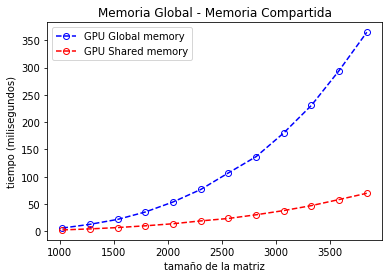

In [16]:

import numpy as np 
import matplotlib.pyplot as plt 

size_matrix=[]
m_global=[]
m_shared=[]

f = open('tiempos.csv', "r")
next(f)  #salto la cabecera
for linea in f: 
	if len(linea.strip())!=0:
		linea=linea.rstrip('\n')  #linea
		dato=linea.split(';')	#lista de la linea
		size_matrix.append(int(dato[0]))
		m_global.append(float(dato[1])) 
		m_shared.append(float(dato[2]))
		
	
f.close()

'''
x = [100, 200, 300, 400, 500, 600, 700]
y1 = [0.436288, 0.900864, 1.802080, 2.902880, 5.539296, 8.498368, 13.178368] 
y2 = [0.559168, 0.665888, 1.138272, 1.811584, 2.642496, 3.699712, 5.389696] 
'''

plt.title("Memoria Global - Memoria Compartida") 
plt.plot(size_matrix, m_global,'-b', label='GPU Global memory', marker='o', linestyle='--', fillstyle='none') 
plt.plot(size_matrix, m_shared,'-r', label='GPU Shared memory', marker='o', linestyle='--', fillstyle='none') 
plt.legend(loc='upper left')
plt.xlabel('tamaño de la matriz')
plt.ylabel('tiempo (milisegundos)')
plt.savefig('comparacion.png')
plt.show() 
